# Assignment 5 (Generative models)

**Submission deadlines:**
- get at least 2 points by Tuesday, 7.05
- remaining points: 28.05

**Points:** Aim to get 12 out of 16 possible points.

**Note:** Below, you can find only two problems. We will announce next problems in the next week.


## Submission instructions
We provide a starter code, however, you are not required to use it as long as you properly solve the tasks.

# Problem 1. Introduction to Gaussian distribution (2 points)

**Tasks:**

Consider the Gaussian distribution
$$ p(z) = \mathcal{N}(z; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(z-\mu)^2}{2\sigma^2}\right),
 \qquad z \in \mathbb{R}.$$

1. **(0.5pt)** Plot the density function for $\mu=0$ and $\sigma^2 \in \{0.5, 1, 2\}$.
  Implement the function `def gaussian_pdf(z, mu, sigma):` and use it to plot the densities.

  Implement the function `def gaussian_sample(n, mu, sigma):` that generates a sample of size $n$ from the Gaussian distribution
	  and plot the histogram (**empirical density**) of the samples for $\mu=0$ and $\sigma^2=1$.
  Use `torch.distributions.Normal` to generate a sample of size $n=1000$ from the Gaussian distribution with $\mu=0$ and $\sigma^2=1$.
  Plot the histogram of the samples. Compare the histogram with the one obtained in the previous step.

2. **(0.5pt)** Generalize the Gaussian distribution to the multivariate Gaussian distribution; see the formula below.
  Implement the function `def gaussian_pdf(z, mu, sigma):` for the multivariate Gaussian distribution (with diagonal covariance matrix)
  and plot the density function for $\mu=[0, 0]$ and $\Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$.
  $$ p(z) = \mathcal{N}(z; \mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^k|\Sigma|}} \exp\left(-\frac{1}{2} (z-\mu)^T \Sigma^{-1} (z-\mu)\right),
 \qquad z \in \mathbb{R}^k.$$

	Also, implement the function `def gaussian_sample(n, mu, sigma):` for the multivariate Gaussian distribution.

3. **(1 pt)** KL divergence between two distributions $p, q$ is defined as
$$ KL(p||q) = \int p(z) \log \frac{p(z)}{q(z)} dz.$$
  
Compute the KL divergence between two Gaussian distributions
$$ p(z) = \mathcal{N}(z; \mu_1, \Sigma_1), \qquad q(z) = \mathcal{N}(z; \mu_2, \Sigma_2).$$
  Implement the function `def kl_divergence_gaussian(mu1, sigma1, mu2, sigma2):` that computes the KL divergence between two multivariate Gaussian distributions.
  Test the function with $\mu_1=[0, 0]$, $\Sigma_1 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$, $\mu_2=[0, 0]$, $\Sigma_2 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$.
  The KL divergence between two identical Gaussian distributions should be zero.


# Problem 2. Variational Autoencoder (3 points)

## Generating 2 Moons dataset

Consider the 2D moons dataset generated in the starter code below.

Train the VAE model on the 2 Moons dataset.

Visualize how the latent space is transformed into data points.
Train a model with 2D latent space.
Then whenever applicable:
1. Plot the data points along with a grid, then plot latent encodings of the data and the grid.
2. Generate latent encodings and a grid in latent space. Then sample data points based on the generated latent space and grid. Plot them in the data space.

Hint: for better visual mapping between original and latent representations of the data, use color on the scatterplots.

Please use the following probability distributions:    
$$
\begin{split}
p(z) &= \mathcal{N}(z; \mu=0, \sigma^2=1)  \\
p(x | z) &= \mathcal{N}(x; \mu=x_{\mu}(z), \sigma^2=x_{\sigma^2})
\end{split}
$$
where: $x_{\mu}(z)$ is computed by a small neural network and $x_{\sigma^2}$ is a learned parameter.

  **Answer these questions:**
  
  1. Write down the formula for the reconstruction loss. The variance appears in two terms, what is their function?

  2. The reconstruction loss may fall below zero. How is this possible?

  Compare the operation of the VAE for 2 Moons with a few widths. How is the loss dependent on the width? Why?
  
**Hints:**
- Use the reparametrization trick to sample from the Gaussian distribution.
- Represent the variance in the neural network as `torch.nn.Parameter(torch.zeros(...))`.
- Represent the variance in the Gaussian distribution as `torch.exp(log_var)` and not as `torch.sqrt(var)`.
  This trick allows to learn the variance, which must be positive, in a more stable way.

# Starter code

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Uniform
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose

device = "cuda" if torch.cuda.is_available() else "cpu"

## Moon dataset

In [2]:
def generate_moons(width=1.0):
    moon1 = [
        [r * np.cos(a) - 2.5, r * np.sin(a) - 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(0, np.pi, 0.01)
    ]
    moon2 = [
        [r * np.cos(a) + 2.5, r * np.sin(a) + 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(np.pi, 2 * np.pi, 0.01)
    ]
    points = torch.tensor(moon1 + moon2)
    points += torch.rand(points.shape) * width
    return points.float()

In [3]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

<ipython-input-3-e26e9d29dce2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = [torch.tensor(tensor) for tensor in tensors]


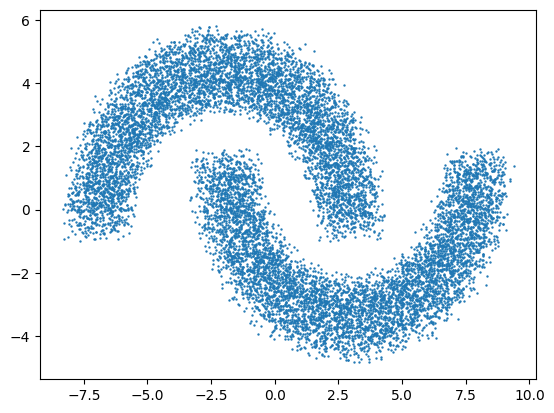

In [9]:
moons = generate_moons(width=1.0)

moons_dl = InMemDataLoader([moons], batch_size=2048, shuffle=True)
moons_dl.to(device)
plt.scatter(moons[:, 0], moons[:, 1], s=0.5)

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, z_dim=2):
        super(VAE, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 2 * z_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, in_dim),
        )

        self.x_log_var = torch.nn.Parameter(torch.zeros(in_dim))

    def forward(self, x):
        sampled_z, z_mu, z_log_var = self.encode(x)
        x_mu, x_log_var = self.decode(sampled_z)
        return x_mu, x_log_var, z_mu, z_log_var

    def encode(self, x):
        # Implement encoding procedure.
        # First, get z_mu and z_log_var from the encoder.
        # Second, compute z samples using the  the reparametrization trick.
        # TODO
        z_mu_log_var = self.encoder(x)
        z_mu, z_log_var = torch.chunk(z_mu_log_var, 2, dim=1)
        epsilon = torch.randn(x.shape[0], z_dim, device=device)
        # print(MultivariateNormal(torch.zeros(z_dim, device=device), torch.eye(z_dim, device=device)).sample((x.shape[0],)).shape)
        # print(epsilon.shape)
        sampled_z = z_mu + torch.exp(z_log_var/2.) * epsilon
        return sampled_z, z_mu, z_log_var

    def decode(self, sampled_z):
        x_mu = self.decoder(sampled_z)
        return x_mu, self.x_log_var

In [ ]:
def gaussian_negative_log_likelihood(x, mu, log_var):
    """Compute N(x; mu=mu, sigma^2=exp(log_var)^2)."""
    return (x-mu)**2 / (2*log_var.exp()) + (np.log(2*np.pi) + log_var)/2


def kullback_leibler_divergence_between_two_gaussians(mu1, log_var1, mu2, log_var2):
    """Compute KL divergence between two Gaussian distributions."""
    return 0.5 * torch.sum(log_var2 - log_var1 + (log_var1.exp() + (mu1 - mu2) ** 2) / log_var2.exp() - 1)


def reconstruction_loss(predicted_x_mu, predicted_x_log_var, real_x):
    """Return the negtive log-likelihood reconstruction loss:
        1/N \sum_i=1^N -\log N(x_i ; predicted_x_mu, I * exp(predicted_x_log_var)^2)
    """
    return gaussian_negative_log_likelihood(x=real_x, mu=predicted_x_mu, log_var=predicted_x_log_var).mean()


def kl_loss(z_mu, z_log_var):
    """Compute Kullback–Leibler divergence between N(z_mu, exp(z_log_var)^2) and N(0,1).

    """
    return kullback_leibler_divergence_between_two_gaussians(z_mu, z_log_var, torch.zeros_like(z_mu) ,torch.ones_like(z_log_var)).mean()

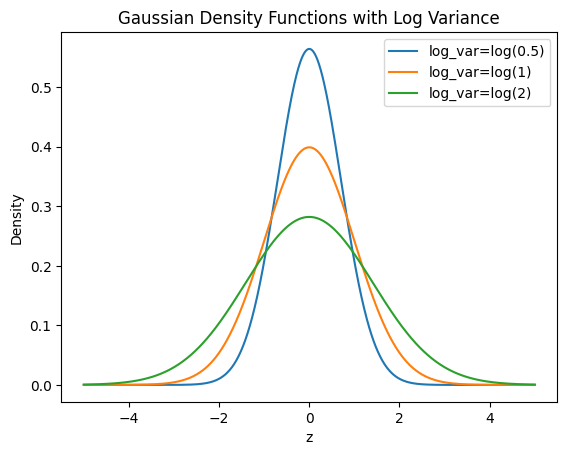

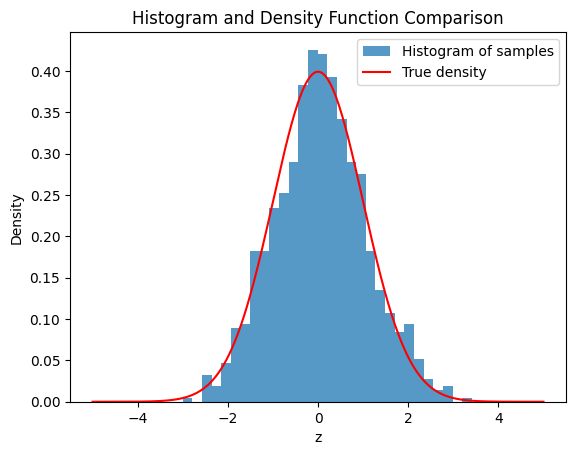

In [ ]:
def gaussian_pdf(z, mu, log_var):
    sigma = torch.exp(log_var / 2)
    factor = 1 / (sigma * torch.sqrt(torch.tensor(2 * np.pi)))
    exponent = torch.exp(-0.5 * ((z - mu) ** 2) / (sigma ** 2))
    return factor * exponent

def gaussian_sample(n, mu, log_var):
    sigma = torch.exp(log_var / 2)
    dist = torch.distributions.Normal(mu, sigma)
    return dist.sample((n,))

z_vals = torch.linspace(-5, 5, 1000)
log_vars = torch.tensor([np.log(0.5), np.log(1), np.log(2)])
labels = ['log_var=log(0.5)', 'log_var=log(1)', 'log_var=log(2)']
for log_var, label in zip(log_vars, labels):
    plt.plot(z_vals, gaussian_pdf(z_vals, 0, log_var), label=label)

plt.title("Gaussian Density Functions with Log Variance")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()

sample = gaussian_sample(1000, 0, torch.log(torch.tensor(1.0)))
plt.hist(sample.numpy(), bins=30, density=True, alpha=0.75, label='Histogram of samples')
plt.plot(z_vals, gaussian_pdf(z_vals, 0, torch.log(torch.tensor(1.0))), 'r-', label='True density')
plt.title("Histogram and Density Function Comparison")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()


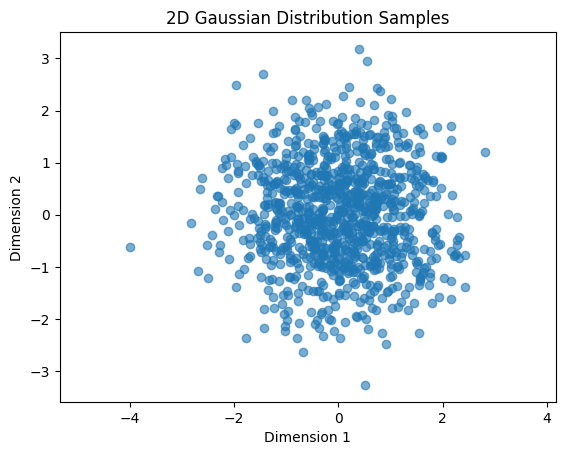

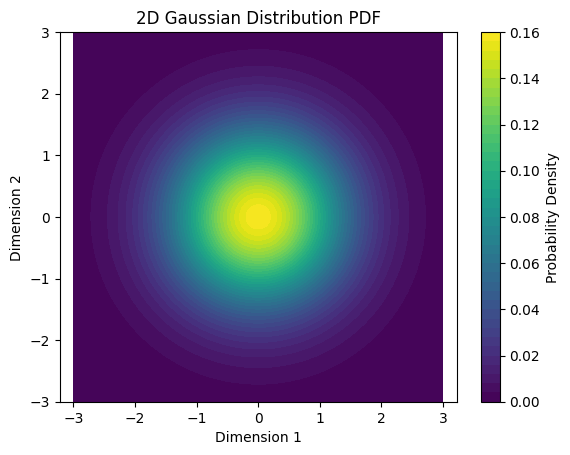

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal

def multivariate_gaussian_pdf(X, Y, mu, sigma):
    X_minus_mu = np.stack([X - mu[0], Y - mu[1]], axis=-1)
    inv_sigma = np.linalg.inv(sigma)
    factor = 1 / np.sqrt((2 * np.pi)**len(mu) * np.linalg.det(sigma))
    """Einsum:
    Take each vector from X_minus_mu
    multiply by inv_sigma
    multiply the result by transpose of the vector from x_minus_mu"""
    result = np.exp(-0.5 * np.einsum('...k,kl,...l->...', X_minus_mu, inv_sigma, X_minus_mu))
    return factor * result

def multivariate_gaussian_sample(n, mu, sigma):
    dist = MultivariateNormal(loc=torch.tensor(mu, dtype=torch.float),
                              covariance_matrix=torch.tensor(sigma, dtype=torch.float))
    return dist.sample((n,))

mu = [0, 0]
sigma = np.array([[1, 0], [0, 1]])
sample_2d = multivariate_gaussian_sample(1000, mu, sigma)
plt.scatter(sample_2d[:, 0], sample_2d[:, 1], alpha=0.6)
plt.title("2D Gaussian Distribution Samples")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.axis('equal')
plt.show()

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

Z = multivariate_gaussian_pdf(X, Y, mu, sigma)

plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Probability Density')
plt.title('2D Gaussian Distribution PDF')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.axis('equal')
plt.show()


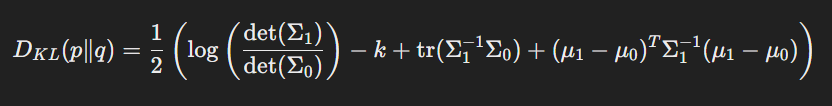

In [ ]:
mu0 = torch.tensor([0.0, 0.0])
mu1 = torch.tensor([0.0, 0.0])

# since I've used log variance in the func, convert variance to log-variance
sigma0 = torch.tensor([1.0, 1.0])
sigma1 = torch.tensor([1.0, 1.0])
log_sigma0 = torch.log(sigma0)
log_sigma1 = torch.log(sigma1)

kl_div = kullback_leibler_divergence_between_two_gaussians(mu0, log_sigma0, mu1, log_sigma1)
print("KL Divergence:", kl_div)


KL Divergence: tensor(0.)


In [ ]:
## Training the VAE

hid_dim = 64
z_dim = 2
lr = 0.0003

vae = VAE(hid_dim=hid_dim, z_dim=z_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

```
Epoch: 0 loss: 15.3017 recon_loss: 15.0352 kl_loss: 0.2665 avg mean: -0.0953 avg std: 1.0014
Epoch: 200 loss: 4.9773 recon_loss: 2.7884 kl_loss: 2.1889 avg mean: -0.0305 avg std: 0.3532
Epoch: 400 loss: 4.9074 recon_loss: 2.7315 kl_loss: 2.1758 avg mean: -0.0215 avg std: 0.3687
Epoch: 600 loss: 4.8669 recon_loss: 2.6247 kl_loss: 2.2422 avg mean: -0.0549 avg std: 0.3756
Epoch: 800 loss: 4.8175 recon_loss: 2.4267 kl_loss: 2.3908 avg mean: 0.0281 avg std: 0.3628
Epoch: 1000 loss: 4.7753 recon_loss: 2.2255 kl_loss: 2.5498 avg mean: -0.0461 avg std: 0.3532
```

Monitor the loss and the generated data.
Stop when the loss converges and data generation is satisfactory.

In [ ]:
# Please note: the model should converge faster!
for i in range(7500):
    recon_loss_acc = 0.0
    kl_acc = 0.0
    vae.train()
    for x, in moons_dl:
        x = x.float().to(device)

        x_mu, x_log_var, z_mu, z_log_var = vae(x)

        optimizer.zero_grad()
        recon_loss = reconstruction_loss(x_mu, x_log_var, x)
        kl = kl_loss(z_mu, z_log_var)
        loss = recon_loss + kl
        loss.backward()
        optimizer.step()

        recon_loss_acc += recon_loss.item() * len(x)
        kl_acc += kl.item() * len(x)

    if i % 200 == 0:
        print(
            f"Epoch: {i} loss: {(recon_loss_acc + kl_acc) / len(moons) :.4f} recon_loss: {recon_loss_acc / len(moons) :.4f} kl_loss: {kl_acc / len(moons) :.4f} avg mean: {z_mu.detach().mean() :.4f} avg std: {torch.exp(z_log_var.detach() / 2).mean() :.4f}"
        )
        vae.eval()
        with torch.no_grad():
            # Reconstruct data
            x_recon = torch.randn(x.shape).to(device) * torch.exp(x_log_var / 2) + x_mu
            x_recon = x_recon.cpu()

            plt.scatter(x_recon[:, 0], x_recon[:, 1])
            plt.title("Reconstruction")
            plt.show()

            # Generate new data
            z = torch.randn(500, z_dim).to(device)
            x_gen_mu, x_gen_log_var = vae.decode(z)
            x_gen = (
                torch.randn(z.shape[0], 2).to(device) * torch.exp(x_gen_log_var / 2)
                + x_gen_mu
            )
            x_gen = x_gen.cpu()

            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title("Generation")
            plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [4]:
def get_grid(data):
    """Generate a dataset of points that lie on grid and span the given data range."""

    xmin, xmax = np.floor(data.min(0)), np.ceil(data.max(0))
    xg, yg = np.meshgrid(
        np.arange(xmin[0], xmax[0] + 1, 1), np.arange(xmin[1], xmax[1] + 1, 1)
    )
    mxg = np.hstack(
        (
            np.hstack((xg, np.zeros((xg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((xg.T, np.zeros((xg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    myg = np.hstack(
        (
            np.hstack((yg, np.zeros((yg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((yg.T, np.zeros((yg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    grid = np.vstack((mxg, myg)).T
    return grid

Text(0.5, 1.0, 'Data in latent space')

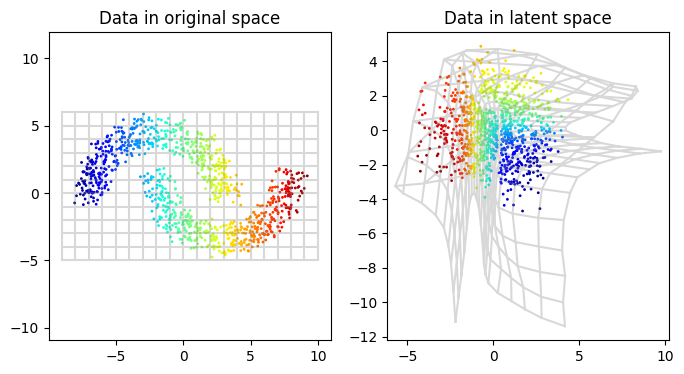

In [ ]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")

vae.eval()

plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid
enc_data = vae.encoder(torch.Tensor(data).to(device)).cpu().detach().numpy()
enc_grid = vae.encoder(torch.Tensor(grid).to(device)).cpu().detach().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")

Text(0.5, 1.0, 'Generated data in original space')

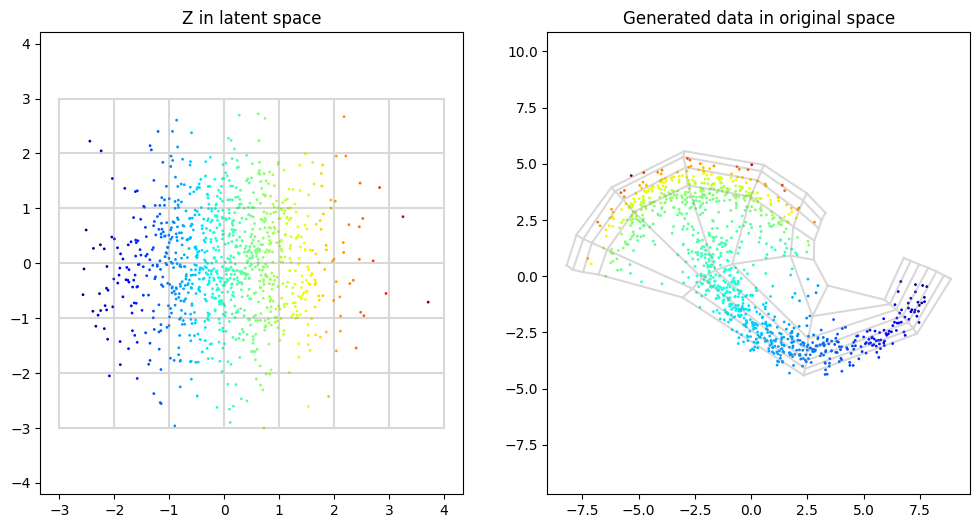

In [ ]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

vae.eval()

# TODO: compute the projection into data space of the latent saples and the grid
x_gen = vae.decoder(torch.Tensor(latent_samples).to(device)).cpu().detach().numpy()
grid_gen = vae.decoder(torch.Tensor(latent_grid).to(device)).cpu().detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

# Problem 3. Generative Adversarial Networks (GANs, 3 points)

Consider the problem defined in **Problem 2**. This time, use the Generative Adversarial Network for sampling the data.

Train your GANs with 2D latent space and visualize the outputs for **Moons datasets**, i.e. visualize how the latent space is transformed into data points.

## Starter code

In [19]:
class Generator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=2):
        super(Generator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
           nn.Linear(in_dim, hid_dim),
           nn.ReLU(),
           nn.Linear(hid_dim, hid_dim),
           nn.ReLU(),
           nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=1):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)

In [20]:
def generator_loss(DG, eps=1e-6):
    # Define Generator loss.
    # Hint: Use eps for numerical stability of log.
    #
    # return TODO
    return -torch.mean(torch.log(DG + eps))



def discriminator_loss(DR, DG, eps=1e-6):
    # Define Discriminator loss.
    # Hint: Use eps for numerical stability of log.

    # return TODO
    return -torch.mean(torch.log(1 - DG + eps) + torch.log(DR + eps))

In [ ]:
z_dim = 2
hid_dim = 64
lr = 0.0001

G = Generator(in_dim=z_dim, hid_dim=hid_dim).to(device)
D = Discriminator(hid_dim=hid_dim).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [ ]:
for i in range(7500):
    G_loss_acc = 0.0
    D_loss_acc = 0.0
    G.train()
    D.train()
    for x, in moons_dl:
        x = x.float().to(device)

        # Generate fake data from z ~ N(0,1).
        # Calculate Generator loss.
        z = torch.randn(x.size(0), z_dim, device=device)
        # x_fake = TODO  # Use the generator to compute x_Fake
        x_fake = G.forward(z)

        # make a copy of x_fake and detach it, we'll use the copy to train the Discriminator
        x_fake_detached = x_fake.detach()

        # G_loss = TODO  # Now use the discriminator and compute generator loss
        G_loss = generator_loss(D(x_fake))
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Calculate Discriminator loss.
        # Remember to use x_fake_detached to prevent backpropagating through generator!
        # D_loss = TODO
        D_loss = discriminator_loss(D(x), D(x_fake_detached))

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        G_loss_acc += G_loss.item() * len(x)
        D_loss_acc += D_loss.item() * len(x)

    if i % 100 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(1000, z_dim, device=device)
            x_gen = G(z).cpu()
            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title(
                f"Epoch: {i} Generator loss: {G_loss_acc / len(moons) :.4f} Discriminator loss: {D_loss_acc / len(moons) :.4f}"
            )
            plt.show()

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'Generated data in original space')

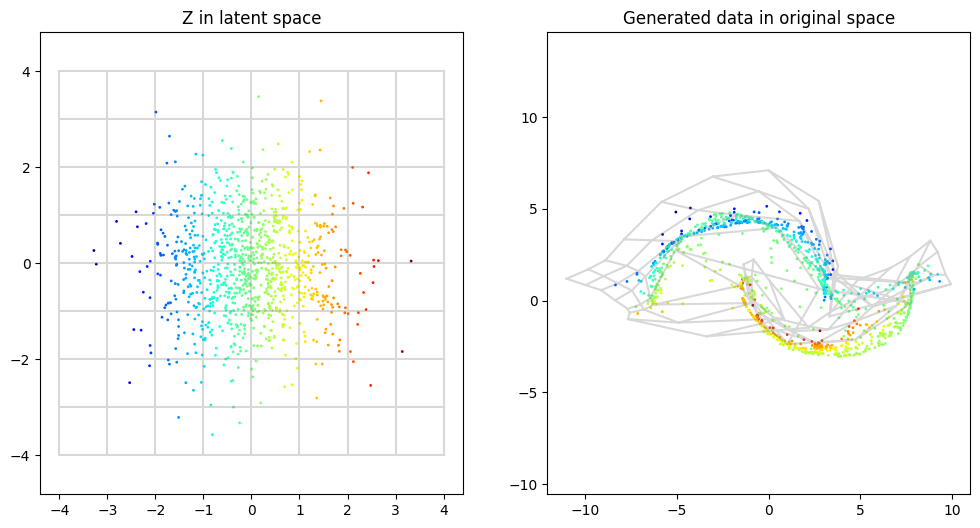

In [ ]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

G.eval()
# TODO: compute the projection into data space of the latent saples and the grid
# x_gen = TODO
# grid_gen = TODO

x_gen = G(torch.Tensor(latent_samples).to(device)).cpu().detach().numpy()
grid_gen = G(torch.Tensor(latent_grid).to(device)).cpu().detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

# Problem 4 (bonus). Generate Moons Dataset with diffusion model (3 pts)

Again, use unsupervised learning and train **Denoising Diffusion Probabilistic Model** (DDPM) on Moons dataset.

* Visualize the denoising process; see the starter code below.

In [5]:
class ConditionalLinear(nn.Module):
    def __init__(self, in_dim, out_dim, n_timesteps):
        super(ConditionalLinear, self).__init__()
        self.out_dim = out_dim
        self.fc = nn.Linear(in_dim, out_dim)
        self.embed = nn.Embedding(n_timesteps, out_dim)
        # self.embed.weight.data.uniform_()

    def forward(self, x, t):
        x = self.fc(x)
        t_emb = self.embed(t)
        x = t_emb.reshape(-1, self.out_dim) * x
        return x

class Denoiser(nn.Module):
    def __init__(self, data_dim, hid_dim, n_timesteps):
        super(Denoiser, self).__init__()

        self.cl1 = ConditionalLinear(data_dim, hid_dim, n_timesteps)
        self.cl2 = ConditionalLinear(hid_dim, hid_dim, n_timesteps)
        self.cl3 = nn.Linear(hid_dim, data_dim)
        self.activation = nn.SiLU()

    def forward(self, x, t):
        x = self.activation(self.cl1(x, t))
        x = self.activation(self.cl2(x, t))
        return self.cl3(x)

In [6]:
class Diffusion(nn.Module):
    def __init__(self, denoiser, n_timesteps=10, data_dim=2, beta_start=1e-5, beta_end=0.999):
        super(Diffusion, self).__init__()
        self.denoiser = denoiser
        self.n_timesteps = n_timesteps
        self.data_dim = data_dim

        self.beta = nn.Parameter(torch.linspace(beta_start, beta_end, n_timesteps), requires_grad=False)
        self.set_params()

    def forward(self, x0):
        timesteps = torch.randint(self.n_timesteps, (x0.shape[0],)).to(x0.device)
        eps, xt = self.get_noisy_sample(x0, timesteps)

        eps_pred = self.denoiser(xt, timesteps)

        # Calculate MSE loss
        # return TODO

        loss = nn.functional.mse_loss(eps_pred, eps)

        return loss

    def sample(self, batch_size=1):
        with torch.no_grad():
            xt = torch.randn(batch_size, self.data_dim).to(self.device)

            for t in reversed(range(self.n_timesteps)):
                timesteps = torch.tensor([t] * xt.shape[0]).to(xt.device)
                eps_pred = self.denoiser(xt, timesteps)
                noise = torch.randn_like(xt)
                # mean, logvar = TODO
                # xt = TODO
                mean, logvar = self.get_p_params(xt, timesteps, eps_pred)
                xt = mean + torch.exp(0.5 * logvar) * noise


        return xt

    def get_p_params(self, xt, timesteps, eps_pred):
        # we use fixed variance schedule for p(x_{t-1} | x_t)
        p_logvar = self.broadcast(torch.log(self.beta[timesteps]), dim=xt.ndim)

        # get mean for p(x_{t-1} | x_t)
        p_mean = self.get_q_params(xt, timesteps, eps_pred)
        return p_mean, p_logvar

    def get_q_params(self, xt, timesteps, eps_pred):

        # predict x0 from xt and eps_pred
        coef1_x0 = self.broadcast(self.coef1_x0[timesteps], dim=xt.ndim)
        coef2_x0 = self.broadcast(self.coef2_x0[timesteps], dim=xt.ndim)
        # x0 = TODO
        x0 = coef1_x0 * xt - coef2_x0 * eps_pred

        # TODO
        # calculate q(x_{t-1} | x_t, x_0)
        coef1_q = self.broadcast(self.coef1_q[timesteps], dim=xt.ndim)
        coef2_q = self.broadcast(self.coef2_q[timesteps], dim=xt.ndim)
        # q_mean = TODO
        q_mean = coef1_q * xt + coef2_q * x0

        return q_mean

    def get_noisy_sample(self, x0, timesteps):
        # TODO
        # sample from q(xt | x0)
        eps = torch.randn_like(x0)
        xt = self.broadcast(torch.sqrt(self.alpha_bar[timesteps]), dim=x0.ndim) * x0 + self.broadcast(torch.sqrt(1 - self.alpha_bar[timesteps]), dim=x0.ndim) * eps
        return eps, xt

    def set_params(self):
        # helper method for all of the constants needed
        self.alpha = nn.Parameter(1 - self.beta, requires_grad=False)
        self.alpha_bar = nn.Parameter(torch.cumprod(self.alpha, dim=0), requires_grad=False)
        self.alpha_bar_prev = nn.Parameter(torch.cat([torch.ones(1,), self.alpha_bar[:-1]]), requires_grad=False)

        # to caluclate x0 from eps_pred
        self.coef1_x0 = nn.Parameter(torch.sqrt(1.0 / self.alpha_bar), requires_grad=False)
        self.coef2_x0 = nn.Parameter(torch.sqrt(1.0 / self.alpha_bar - 1), requires_grad=False)

        # for q(x_{t-1} | x_t, x_0)
        self.coef1_q = nn.Parameter(self.beta * torch.sqrt(self.alpha_bar_prev) / (1.0 - self.alpha_bar), requires_grad=False)
        self.coef2_q = nn.Parameter((1.0 - self.alpha_bar_prev) * torch.sqrt(self.alpha) / (1.0 - self.alpha_bar), requires_grad=False)

    def broadcast(self, arr, dim=2):
        # helper method to increase tensor's dimension number
        while arr.dim() < dim:
            arr = arr[:, None]
        return arr.to(self.device)

    @property
    def device(self):
        return next(self.denoiser.parameters()).device

In [7]:
hid_dim = 128
data_dim = 2
n_timesteps = 10
lr = 0.001

denoiser = Denoiser(data_dim, hid_dim, n_timesteps)
diffusion = Diffusion(denoiser, n_timesteps=n_timesteps, data_dim=data_dim).to(device)
optimizer = optim.Adam(diffusion.parameters(), lr=lr)

In [10]:
timesteps = torch.arange(n_timesteps)
x0 = next(iter(moons_dl))[0] #/ torch.tensor([8, 6]).to(device)

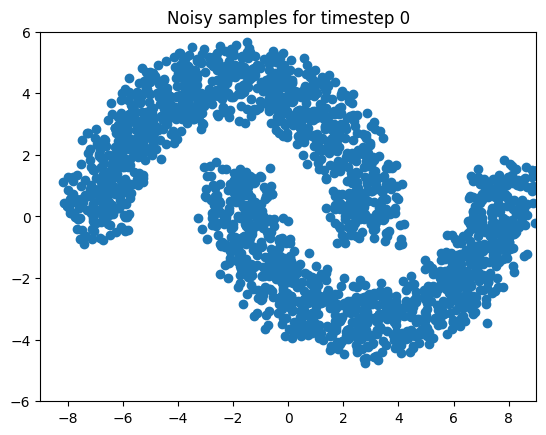

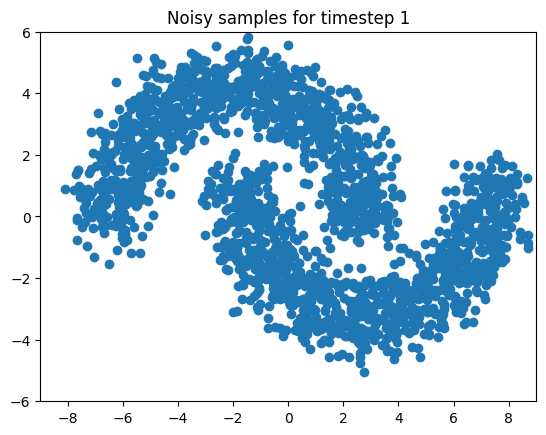

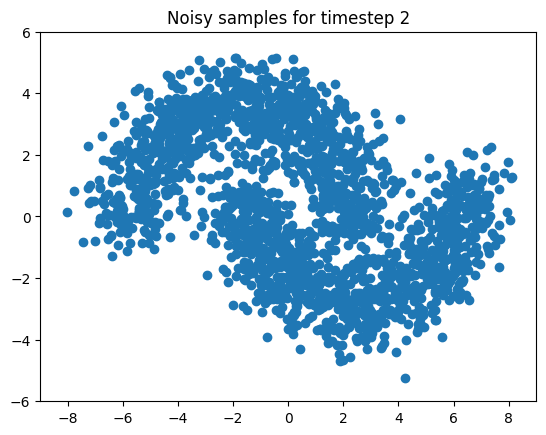

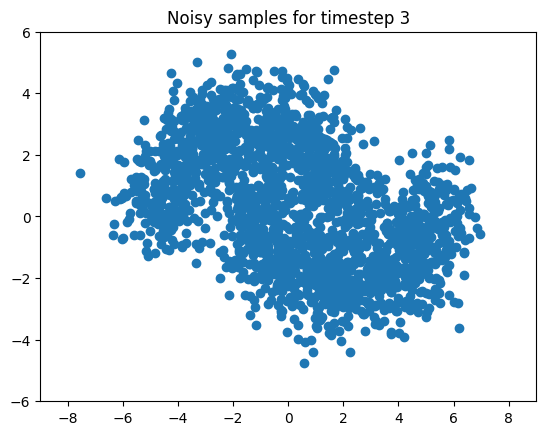

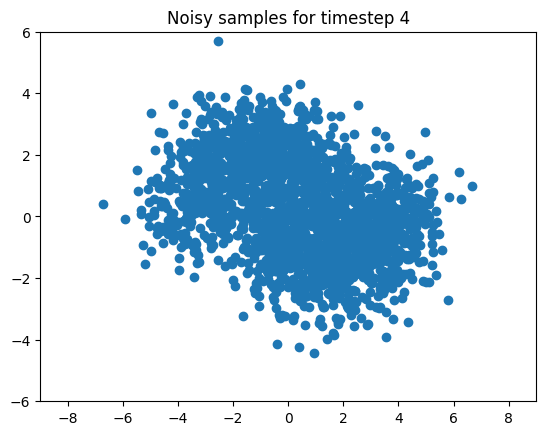

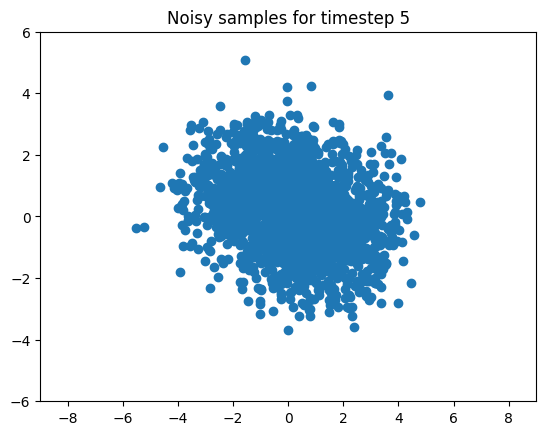

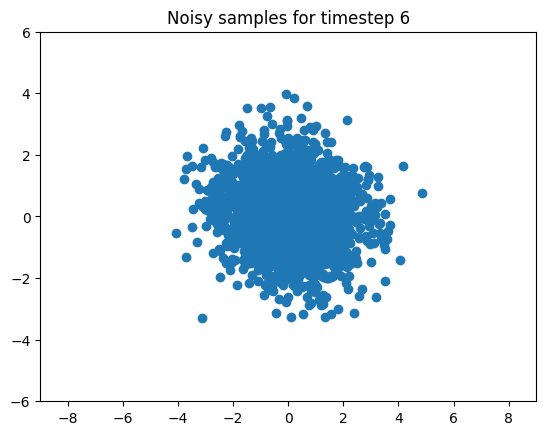

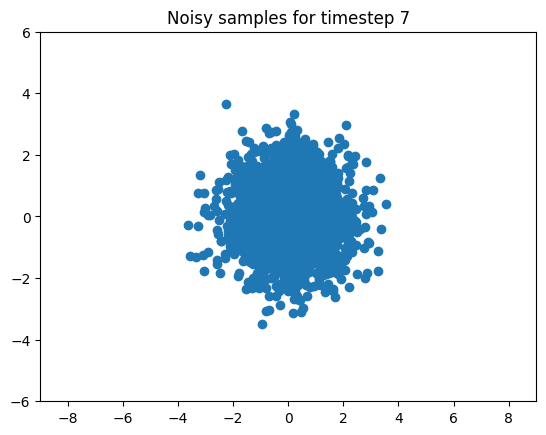

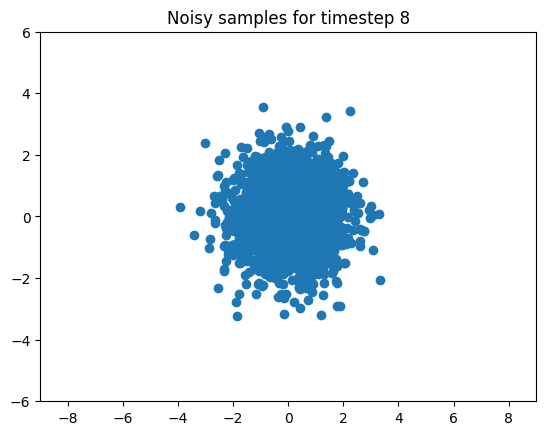

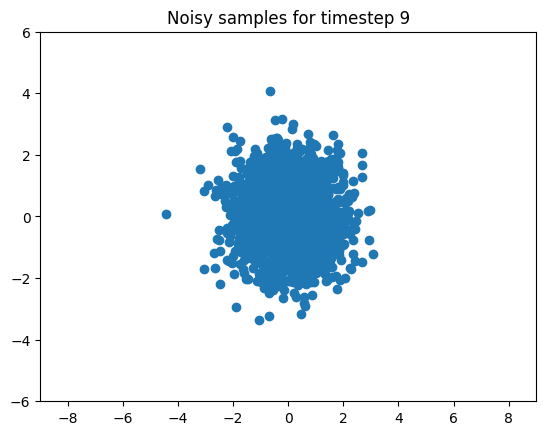

In [11]:
for t in timesteps[::1]:
    t = torch.zeros(x0.shape[0]) + t
    xt = diffusion.get_noisy_sample(x0, t.int())[1]
    xt = xt.cpu()
    plt.figure()
    plt.xlim([-9, 9])
    plt.ylim([-6, 6])
    plt.scatter(xt[:, 0], xt[:, 1])
    plt.title(f'Noisy samples for timestep {t[0].int()}')

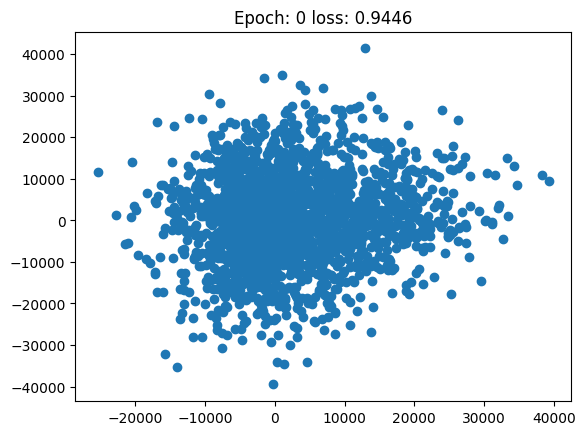

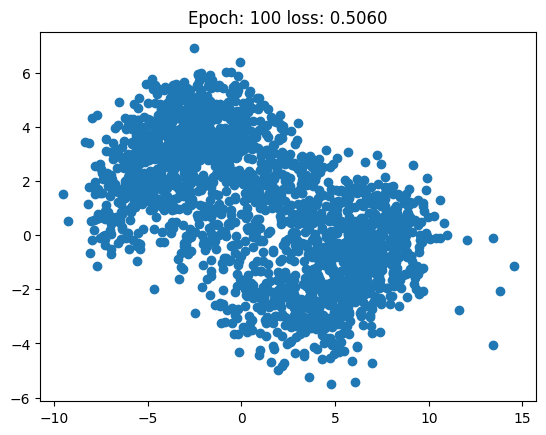

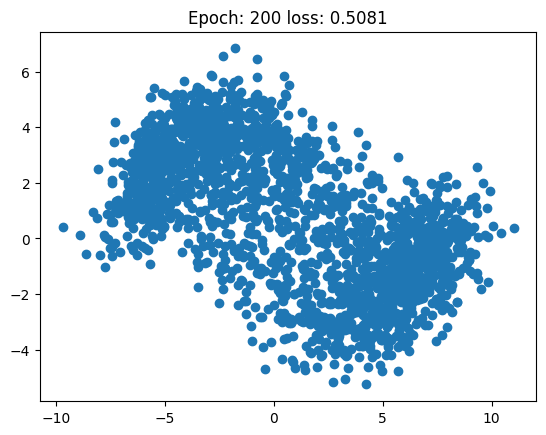

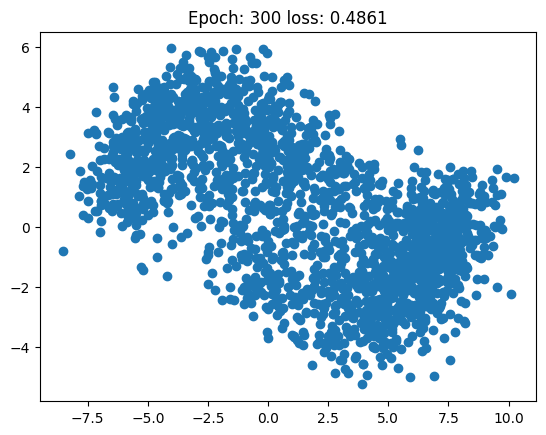

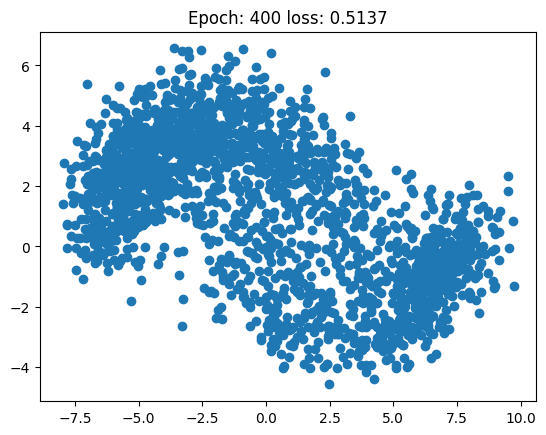

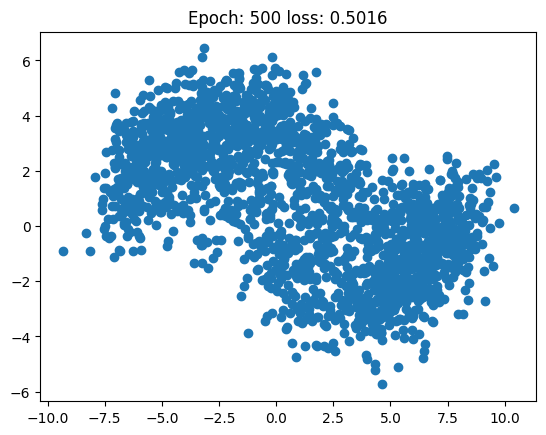

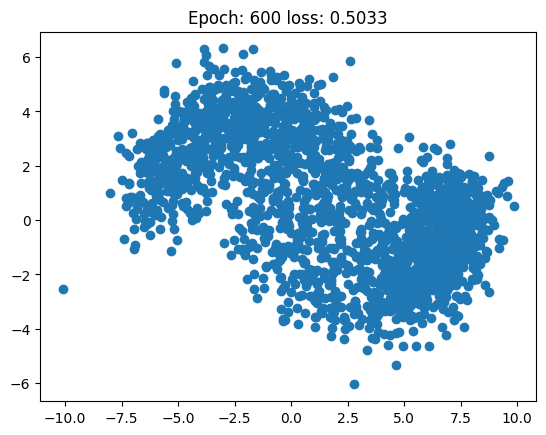

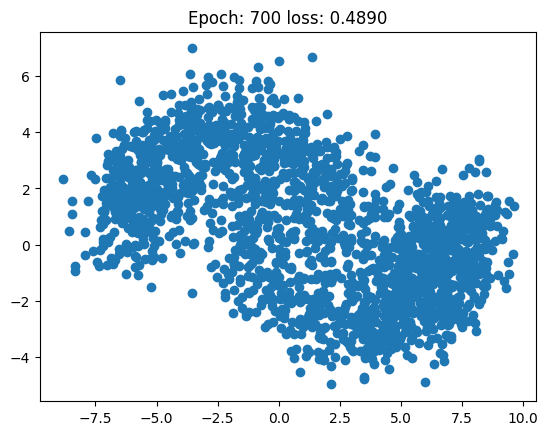

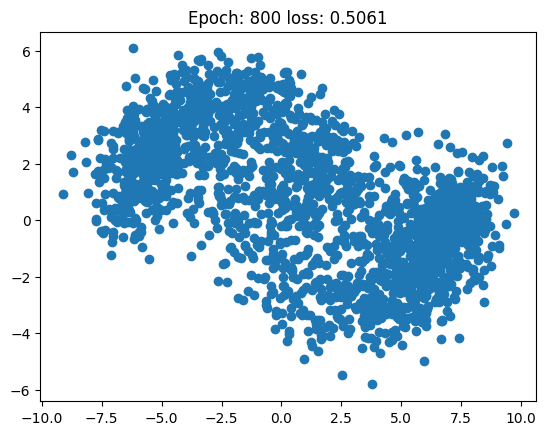

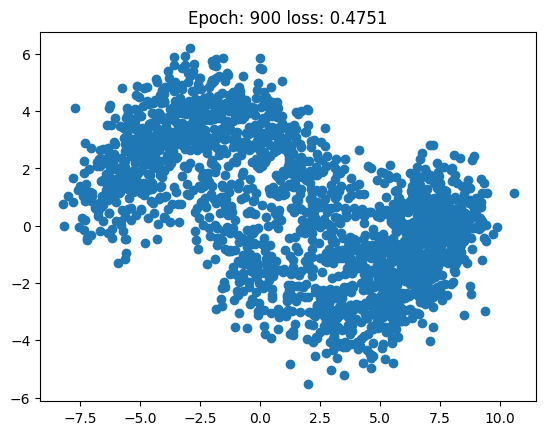

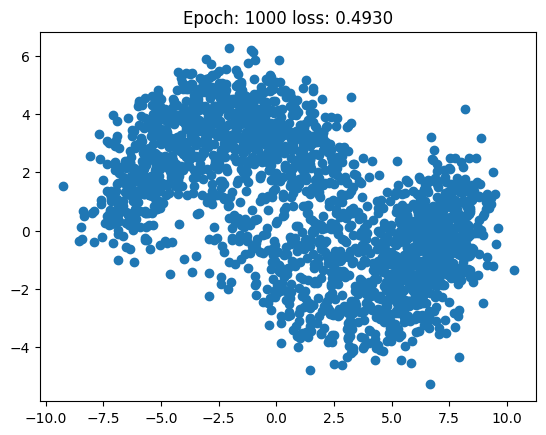

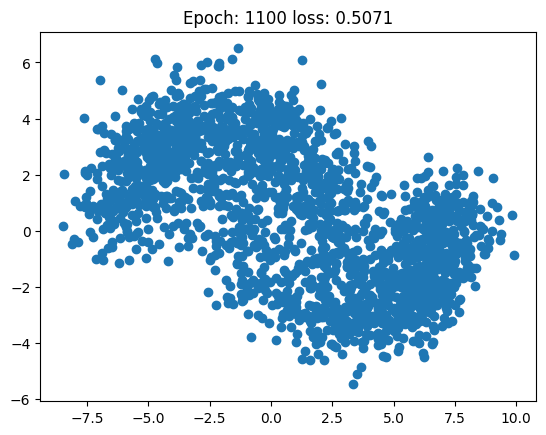

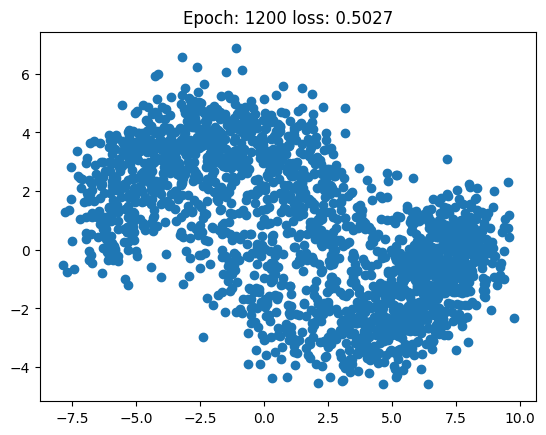

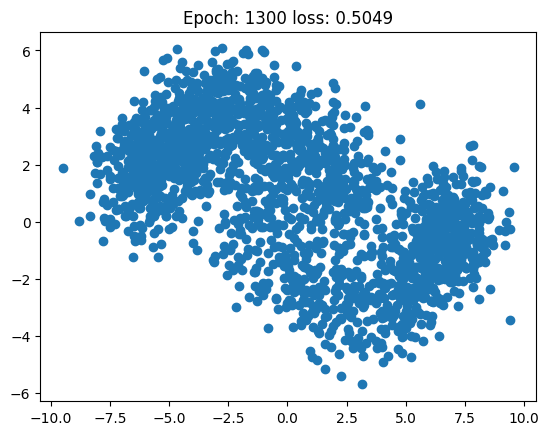

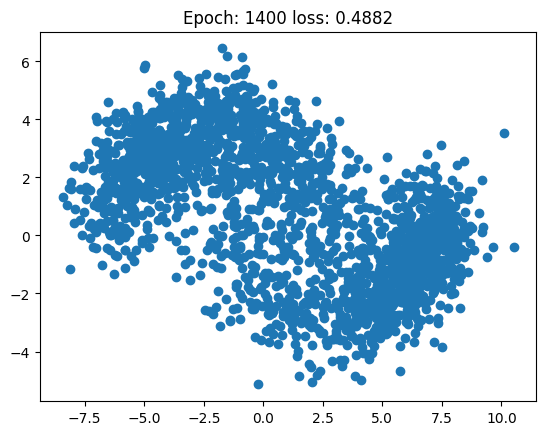

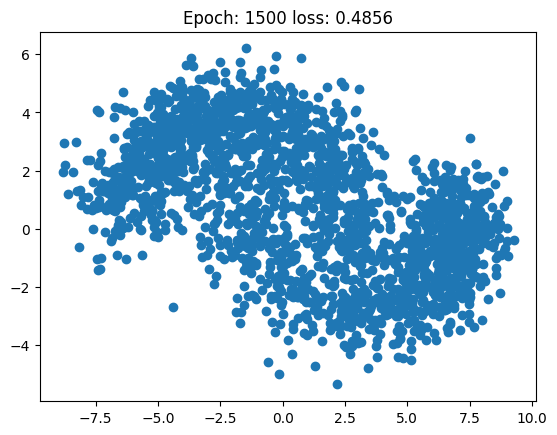

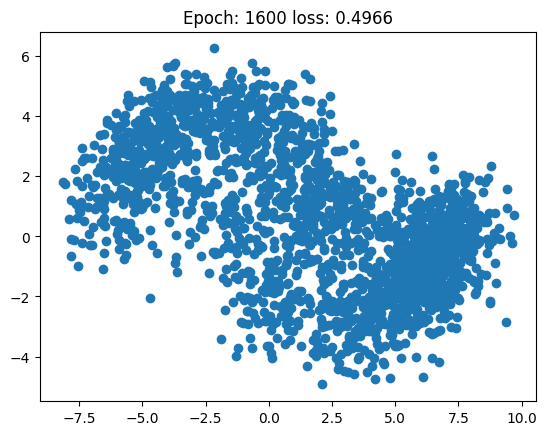

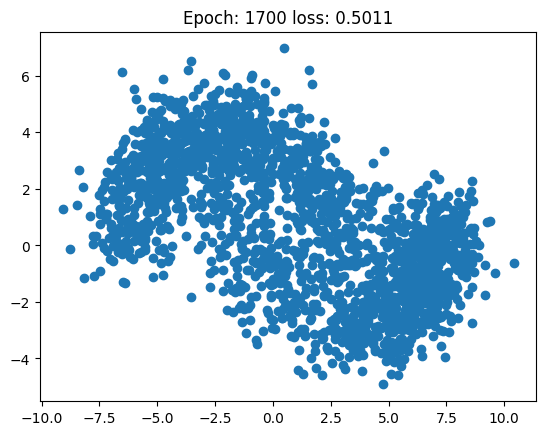

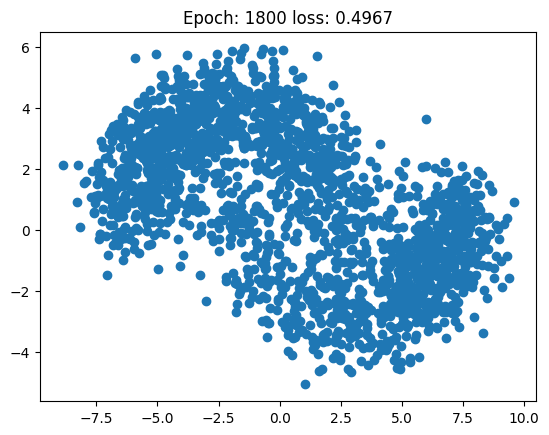

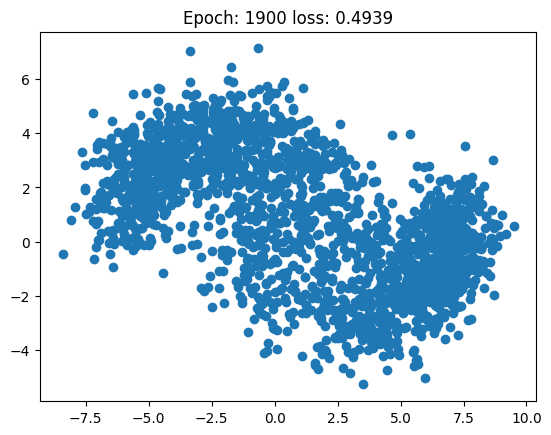

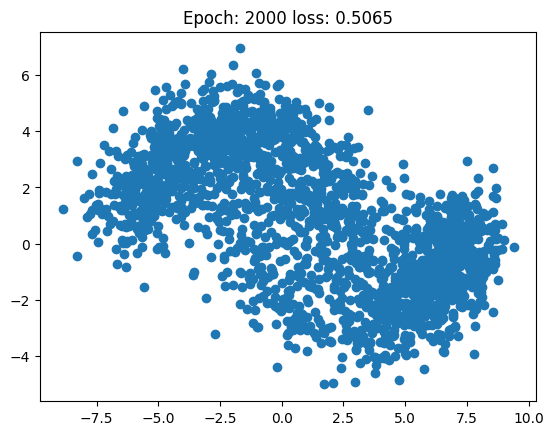

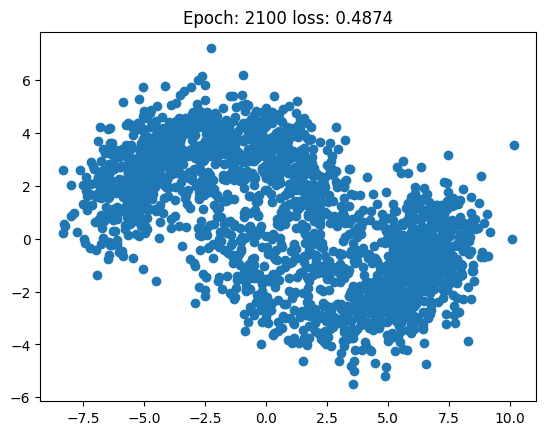

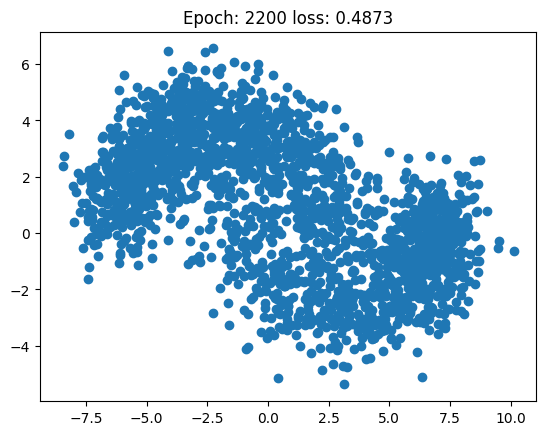

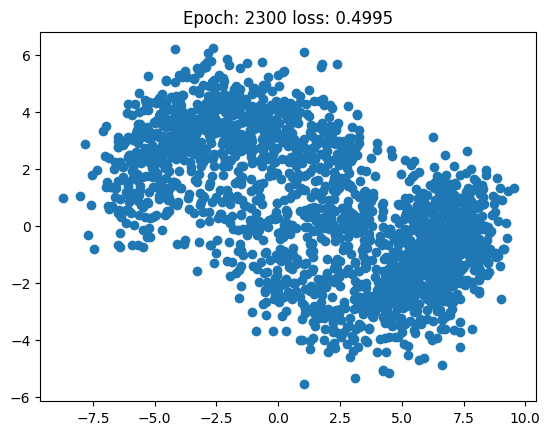

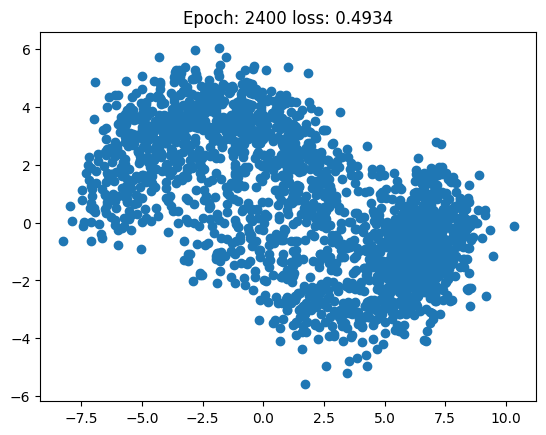

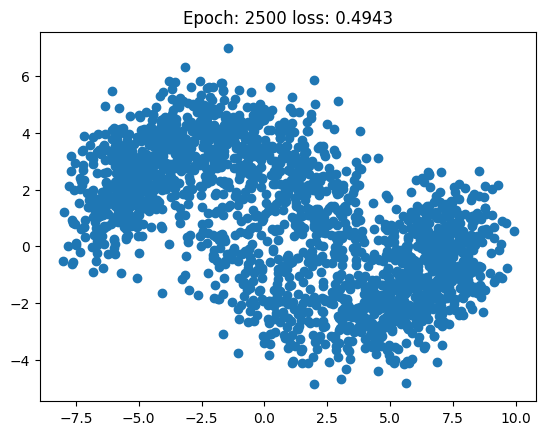

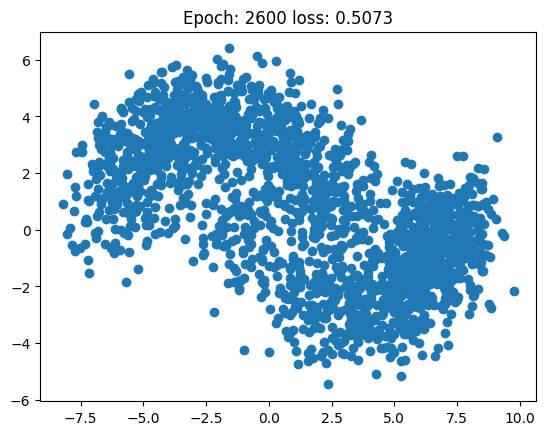

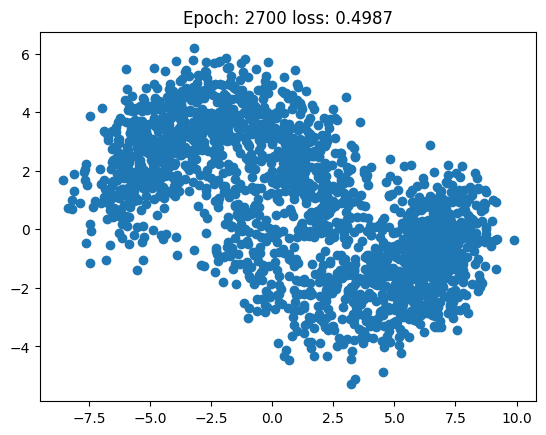

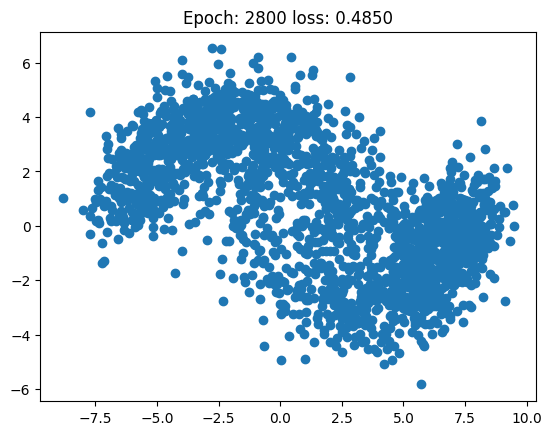

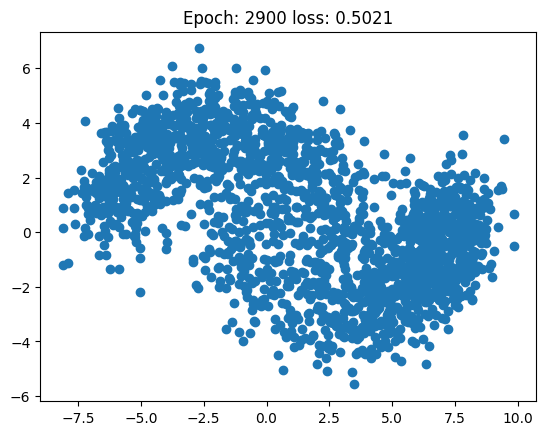

In [12]:
for i in range(3000):
    loss_acc = 0.0
    diffusion.train()
    for x0, in moons_dl:
        x0 = x0.float()
        # x0 += torch.randn_like(x0) * 1e-3

        optimizer.zero_grad()
        loss = diffusion(x0)
        loss.backward()
        optimizer.step()

        loss_acc += loss.item()

    if i % 100 == 0:
        diffusion.eval()
        with torch.no_grad():
            samples = diffusion.sample(2048)
            samples = samples.cpu()

            plt.scatter(samples[:, 0], samples[:, 1])
            plt.title(f"Epoch: {i} loss: {loss_acc / len(moons_dl) :.4f}")
            plt.show()

# Problem 5. Generating images from `TBA` dataset (4 pts).

Choose any generative model (e.g. VAE, GAN, RealNVP or DDPM) to generate samples from `<TBA>` dataset. Quick Draw Google or MNIST

In [13]:
!gdown https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy

Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
To: /content/bird.npy
100% 105M/105M [00:01<00:00, 69.4MB/s] 


In [14]:
bird_images = np.load("bird.npy").reshape(-1, 28, 28)

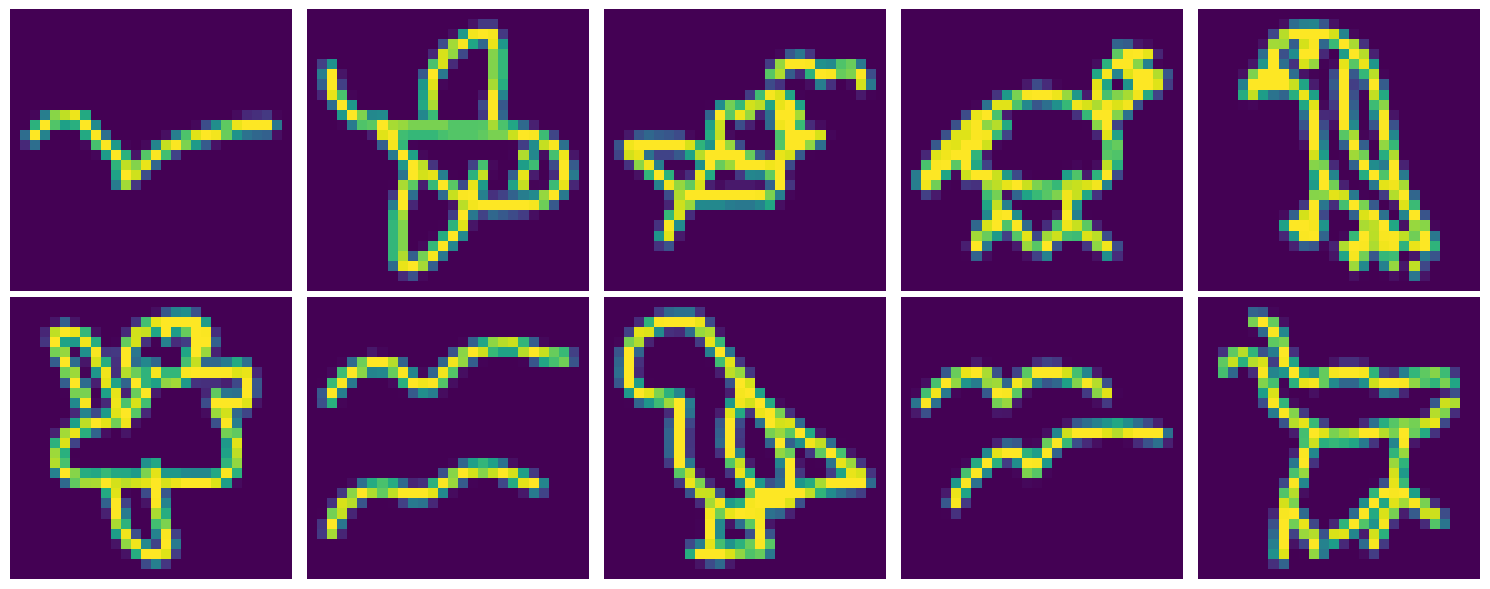

In [15]:
rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
for row in range(rows):
    for col in range(cols):
        axes[row, col].imshow(bird_images[row * cols + col])
        axes[row, col].axis("off")
plt.tight_layout()

In [16]:
class NumpyDataset(Dataset):
    def __init__(self, images):
        self.images = torch.from_numpy(images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [17]:
birds_dataset = NumpyDataset(bird_images)
birds_dataloader = DataLoader(birds_dataset, batch_size=16)

for imgs in birds_dataloader:
    print(imgs)
    break

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [26]:
class Generator(nn.Module):
    def __init__(self, in_dim=100, hid_dim=128, out_dim=784):
        super(Generator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
           nn.Linear(self.in_dim, hid_dim),
           nn.ReLU(),
           nn.Linear(hid_dim, hid_dim),
           nn.ReLU(),
           nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        x = self.layers(x)
        return x.view(-1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self, in_dim=784, hid_dim=128, out_dim=1):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, self.in_dim)
        return self.layers(x)


In [27]:
z_dim = 2
hid_dim = 64
lr = 0.0001

G = Generator(in_dim=z_dim, hid_dim=hid_dim).to(device)
D = Discriminator(hid_dim=hid_dim).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

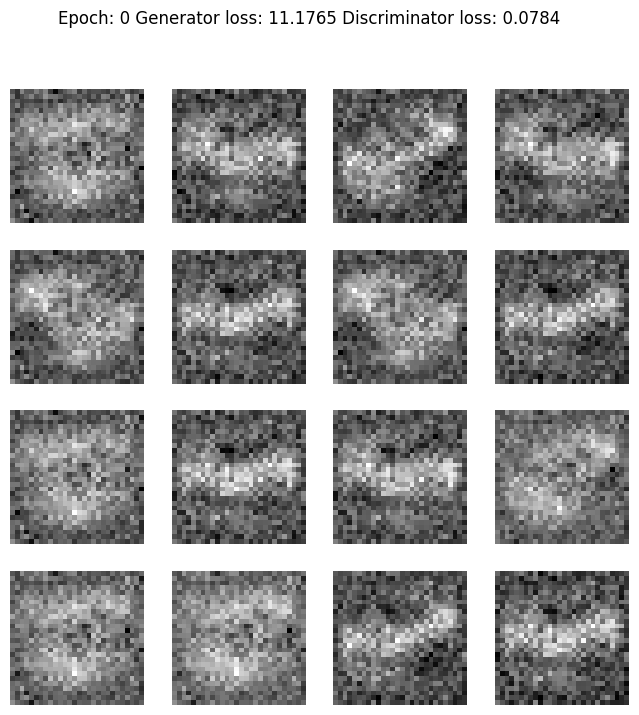

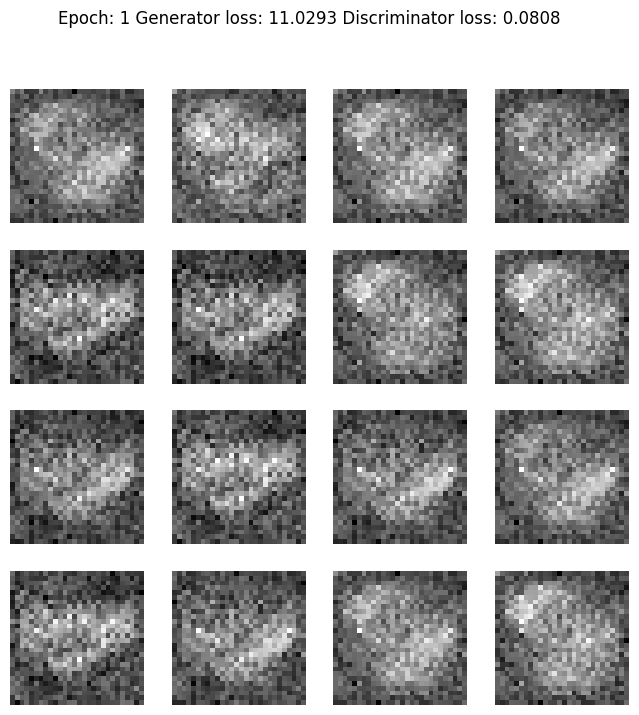

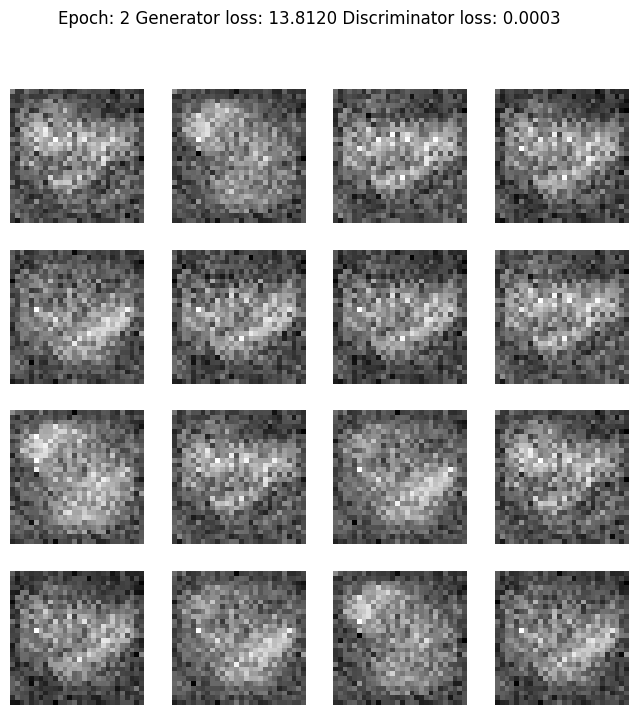

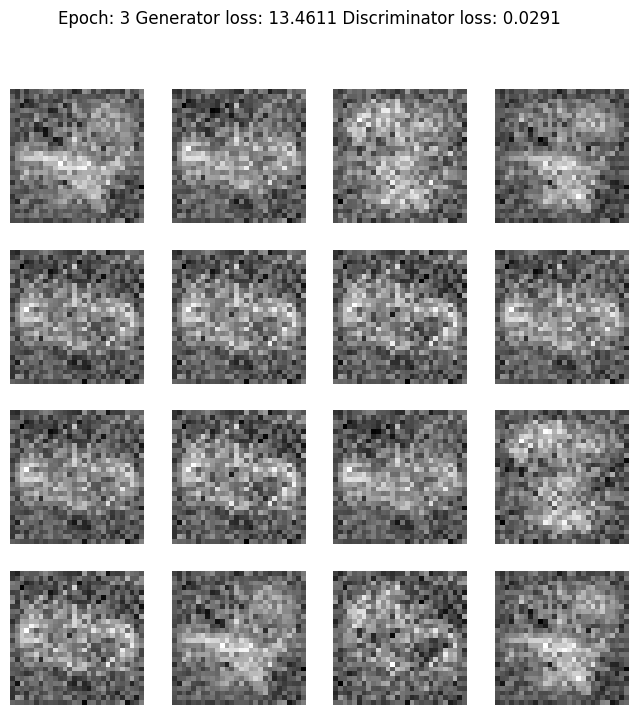

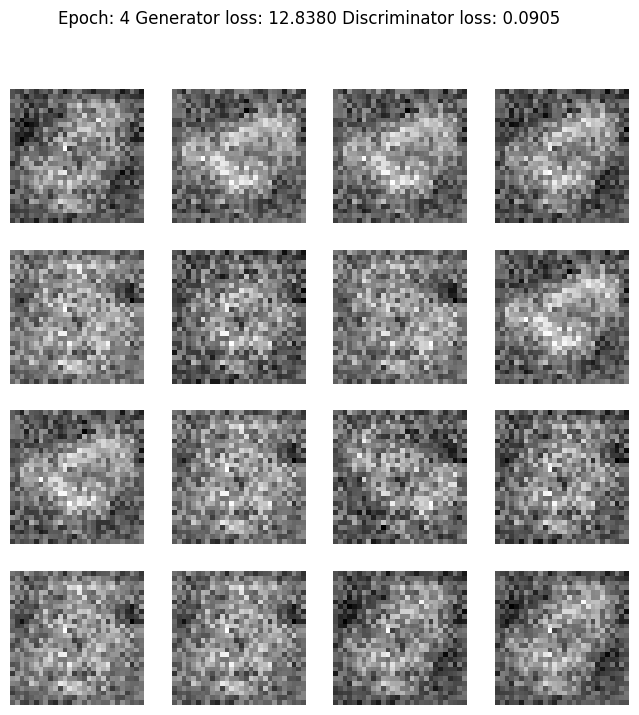

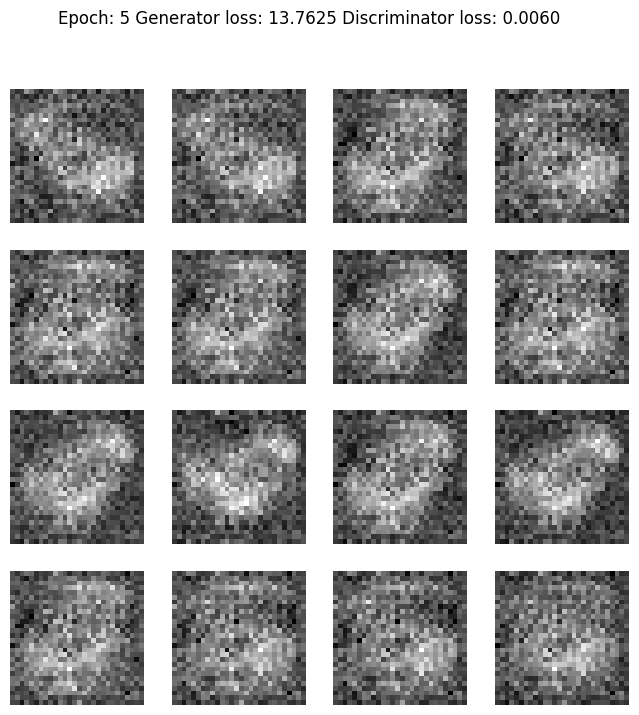

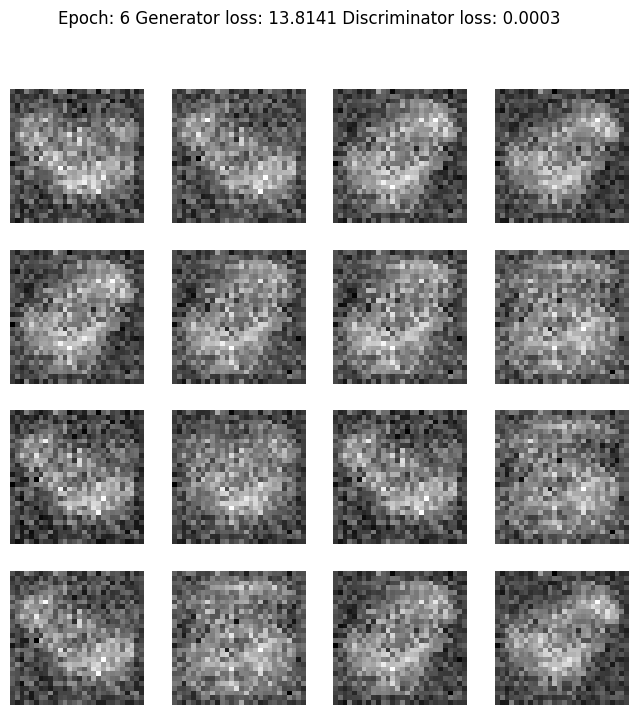

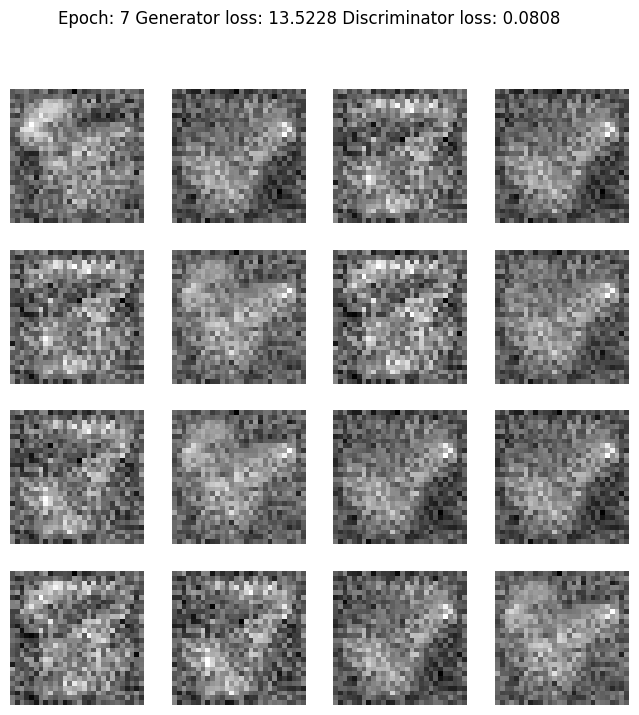

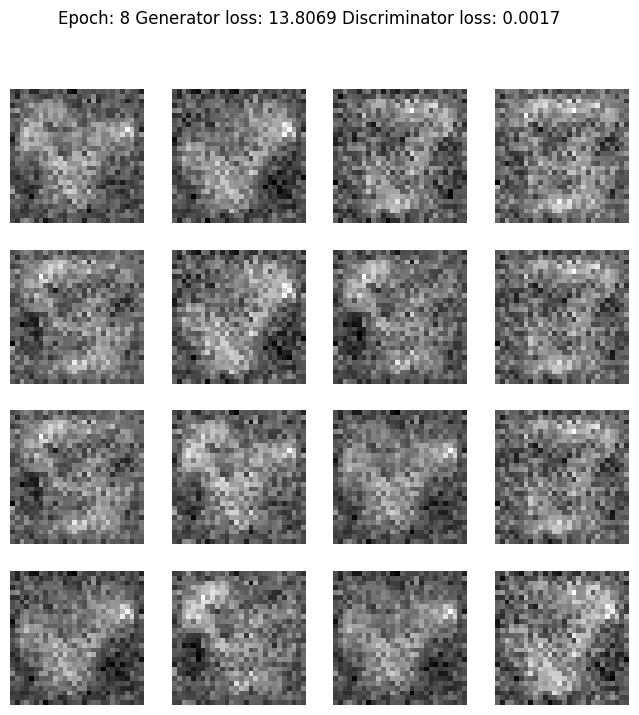

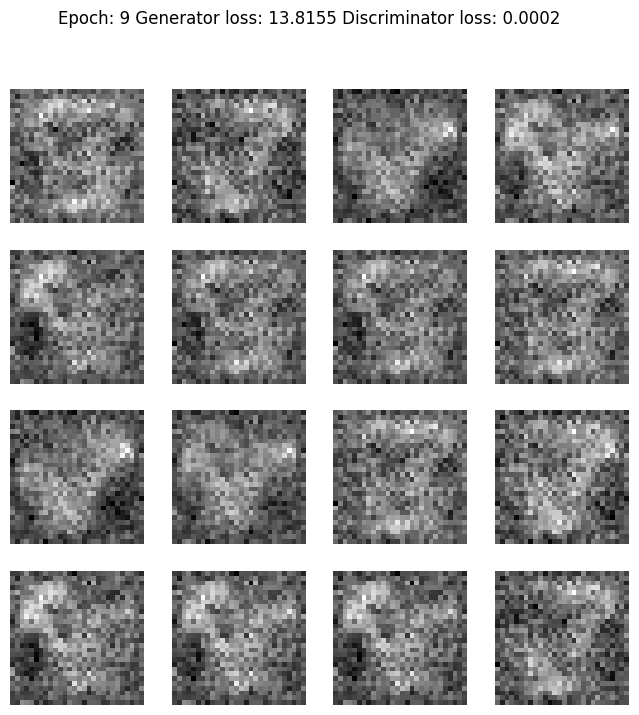

In [32]:
for i in range(10):
    G_loss_acc = 0.0
    D_loss_acc = 0.0
    G.train()
    D.train()
    for x in birds_dataloader:
        x = x.float().to(device)
        z = torch.randn(x.size(0), z_dim, device=device)
        x_fake = G.forward(z)

        x_fake_detached = x_fake.detach()

        G_loss = generator_loss(D(x_fake))
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        D_loss = discriminator_loss(D(x), D(x_fake_detached))

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        G_loss_acc += G_loss.item() * len(x)
        D_loss_acc += D_loss.item() * len(x)

    G.eval()
    with torch.no_grad():
        z = torch.randn(16, z_dim, device=device)
        x_gen = G(z).cpu()

        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        for ax, img in zip(axes.flatten(), x_gen):
            ax.imshow(img.reshape(28, 28), cmap='gray')
            ax.axis('off')
        plt.suptitle(f"Epoch: {i} Generator loss: {G_loss_acc / len(birds_dataset) :.4f} Discriminator loss: {D_loss_acc / len(birds_dataset) :.4f}")
        plt.show()
